In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 100.0

# Environment

## Distribution A

In [2]:
from numpy.random import RandomState
from scipy.stats import truncnorm


def sample_mixture_truncnorm(n: int, random_state: RandomState = None) -> np.array:
    if random_state is None:
        random_state = RandomState()

    scale = 0.1

    loc = -0.6
    a, b = (-1.0 - loc) / scale, (1.0 - loc) / scale
    pos_samples = truncnorm.rvs(
        a, b, loc=loc, scale=scale, size=2 * n, random_state=random_state
    )

    loc = 0.4
    a, b = (-1.0 - loc) / scale, (1.0 - loc) / scale
    neg_samples = truncnorm.rvs(
        a, b, loc=loc, scale=scale, size=2 * n, random_state=random_state
    )

    all_samples = np.concatenate([pos_samples, neg_samples], axis=None)
    random_state.shuffle(all_samples)

    return all_samples.reshape((-1, 2))[:n]

(-1.0, 1.0)

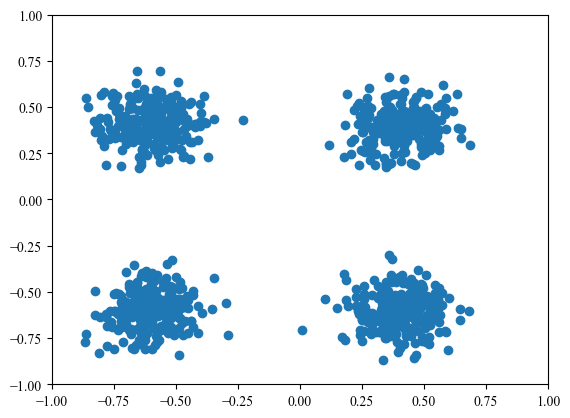

In [3]:
truncnorm_data = sample_mixture_truncnorm(1000)
plt.scatter(truncnorm_data[:, 0], truncnorm_data[:, 1])
# plt.scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6])

ax = plt.gca()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

## Distribution B

In [4]:
from sklearn import datasets


def sample_moons(size: int):
    samples, _ = datasets.make_moons(n_samples=size, shuffle=True, noise=0.02)
    samples[:, 0] -= 0.5
    samples[:, 1] -= 0.2
    samples[:, 0] /= 2.0

    return samples

(-1.0, 1.0)

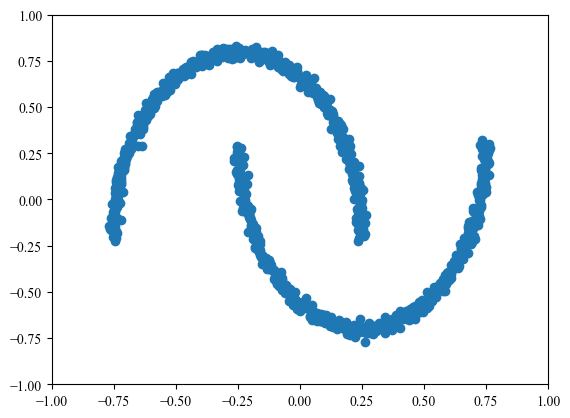

In [5]:
moons_data = sample_moons(1000)
plt.scatter(moons_data[:, 0], moons_data[:, 1])

ax = plt.gca()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Naive K-Means++

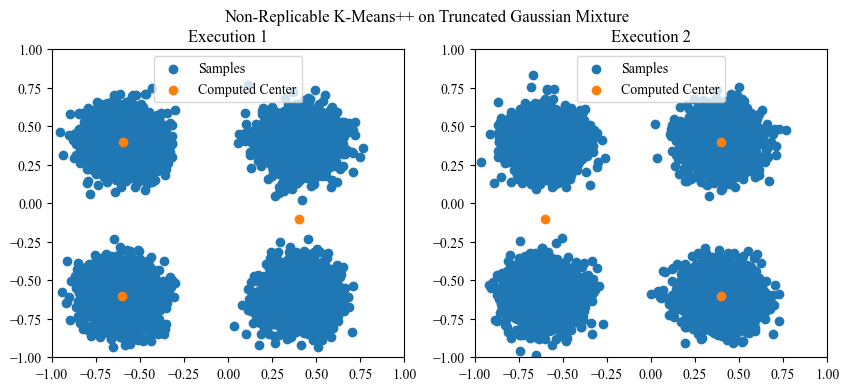

In [6]:
from sklearn.cluster import KMeans

truncnorm_data1 = sample_mixture_truncnorm(1_200_00)
truncnorm_data2 = sample_mixture_truncnorm(1_200_00)
truncnorm_kmeans1 = KMeans(n_clusters=3).fit(truncnorm_data1)
truncnorm_kmeans2 = KMeans(n_clusters=3).fit(truncnorm_data2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

truncnorm_data_indices1 = np.random.choice(
    truncnorm_data1.shape[0], 10000, replace=False
)

ax[0].scatter(
    truncnorm_data1[truncnorm_data_indices1, 0],
    truncnorm_data1[truncnorm_data_indices1, 1],
    label="Samples",
)
# ax[0].scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6])
ax[0].scatter(
    truncnorm_kmeans1.cluster_centers_[:, 0],
    truncnorm_kmeans1.cluster_centers_[:, 1],
    label="Computed Center",
)

ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()
ax[0].set_title("Execution 1")

truncnorm_data_indices2 = np.random.choice(
    truncnorm_data2.shape[0], 10000, replace=False
)

ax[1].scatter(
    truncnorm_data2[truncnorm_data_indices2, 0],
    truncnorm_data2[truncnorm_data_indices2, 1],
    label="Samples",
)
# ax[1].scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6])
ax[1].scatter(
    truncnorm_kmeans2.cluster_centers_[:, 0],
    truncnorm_kmeans2.cluster_centers_[:, 1],
    label="Computed Center",
)

ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].legend()
ax[1].set_title("Execution 2")

fig.suptitle("Non-Replicable K-Means++ on Truncated Gaussian Mixture")

plt.savefig("truncnorm.pdf", format="pdf", bbox_inches="tight")

plt.show()

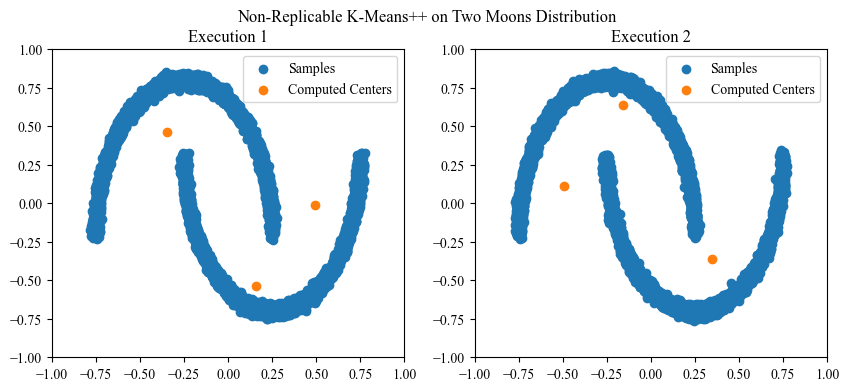

In [7]:
moons_data1 = sample_moons(1_200_00)
moons_data2 = sample_moons(1_200_00)
moons_kmeans1 = KMeans(n_clusters=3).fit(moons_data1)
moons_kmeans2 = KMeans(n_clusters=3).fit(moons_data2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

moons_data_indices1 = np.random.choice(moons_data1.shape[0], 10000, replace=False)

ax[0].scatter(
    moons_data1[moons_data_indices1, 0],
    moons_data1[moons_data_indices1, 1],
    label="Samples",
)
ax[0].scatter(
    moons_kmeans1.cluster_centers_[:, 0],
    moons_kmeans1.cluster_centers_[:, 1],
    label="Computed Centers",
)

ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()
ax[0].set_title("Execution 1")

moons_data_indices2 = np.random.choice(moons_data2.shape[0], 10000, replace=False)

ax[1].scatter(
    moons_data2[moons_data_indices2, 0],
    moons_data2[moons_data_indices2, 1],
    label="Samples",
)
ax[1].scatter(
    moons_kmeans2.cluster_centers_[:, 0],
    moons_kmeans2.cluster_centers_[:, 1],
    label="Computed Centers",
)

ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].legend()
ax[1].set_title("Execution 2")

fig.suptitle("Non-Replicable K-Means++ on Two Moons Distribution")

plt.savefig("moons.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Replicable K-Means++

## Replicable Heavy Hitters

In [8]:
from numpy.random import RandomState


def get_idx_intersect(A, B):
    return (A[:, None] == B).all(-1).any(1)


# 1-dimensional
def r_heavy_hitters(
    sampler, thres: float, eps: float, rho: float, random_state: RandomState = None
):
    print("r_heavy_hitters...")
    assert 0 < thres < 1
    assert 0 < eps < thres

    if random_state is None:
        random_state = RandomState()

    n1 = int(np.ceil(np.log(5 / (rho * (thres - eps))) / (thres - eps)))
    print(n1)
    candidates = sampler(size=n1)
    candidates = np.unique(candidates, axis=0)

    n2 = int(
        np.ceil(
            (np.log(5 / rho) + (np.sqrt(n1) + 1) * np.log(2))  # * 50
            / (rho**2 * eps**2)  # / 1e2
        )
    )
    print(n2)
    samples = sampler(size=n2)

    unique_samples, count = np.unique(samples, axis=0, return_counts=True)
    count = count.astype(float) / n2

    rand_thres = random_state.uniform(thres - eps, thres)
    print(count, rand_thres, n1 + n2)

    # magic intersection https://stackoverflow.com/a/67113105
    # get_idx_intersect(unique_samples, candidates)
    _, idx_intersect, _ = np.intersect1d(
        unique_samples, candidates, return_indices=True
    )

    unique_samples_intersect = unique_samples[idx_intersect]
    count_intersect = count[idx_intersect]
    return unique_samples_intersect[count_intersect >= rand_thres]

In [9]:
def toy_sampler(size: int, random_state: RandomState = None):
    if random_state is None:
        random_state = RandomState()

    return np.random.choice([0, 1, 2], p=[0.3, 0.3, 0.4], size=size).reshape((-1, 1))


print(
    r_heavy_hitters(
        toy_sampler, thres=0.4, eps=0.1, rho=0.3, random_state=RandomState(2)
    )
)
print(
    r_heavy_hitters(
        toy_sampler, thres=0.4, eps=0.1, rho=0.3, random_state=RandomState(2)
    )
)

r_heavy_hitters...
14
6778
[0.29949838 0.29949838 0.40100325] 0.3435994902142004 6792
[[2]]
r_heavy_hitters...
14
6778
[0.30525229 0.30908823 0.38565949] 0.3435994902142004 6792
[[2]]


## Replicable Quad Tree

In [10]:
from itertools import product


class QuadTreeNode:
    offsets = [np.array([dx, dy]) for dx, dy in product([-1.0, 1.0], repeat=2)]

    def __init__(
        self, point: np.array, radius: float, is_heavy: bool = False, parent=None
    ):
        self.point = point
        self.radius = radius
        self.is_heavy = is_heavy
        self.children = [None] * 4
        self.parent = parent

    def get_heavy_nodes(self):
        heavy_nodes = []

        def _explore(node):
            if not node.is_heavy:
                return

            heavy_nodes.append(node.point.reshape((1, -1)))
            for child in node.children:
                _explore(child)

        _explore(self)
        return np.concatenate(heavy_nodes, axis=0)

    def get_leaves(self):
        leaves = []

        # return true if found node
        def _explore(node) -> bool:
            has_heavy_child = False
            for child in node.children:
                if child is not None and child.is_heavy:
                    _explore(child)
                    has_heavy_child = True

            if not has_heavy_child:
                leaves.append(node.point.reshape((1, -1)))

            return has_heavy_child

        _explore(self)
        return np.concatenate(leaves, axis=0)

In [11]:
def make_children(nodes):
    child_nodes = []
    for node in nodes:
        radius = node.radius
        for idx, d in enumerate(QuadTreeNode.offsets):
            next_point = node.point + d * radius / 2
            child_node = QuadTreeNode(next_point, radius / 2, parent=node)

            node.children[idx] = child_node
            child_nodes.append(child_node)

    return child_nodes


def get_idx_sampler(sampler, nodes):
    def _idx_sampler(size: int):
        samples = sampler(size)
        idx_samples = [len(nodes)] * size
        for i in range(size):
            for j in range(len(nodes)):
                if (
                    np.linalg.norm(samples[i] - nodes[j].point, ord=np.inf)
                    <= nodes[j].radius
                ):
                    idx_samples[i] = j
        return idx_samples

    return _idx_sampler

In [12]:
from numpy.random import RandomState


def r_quad_tree(
    sampler,
    k: int,
    eps: float,
    rho: float,
    Gamma: float,
    beta: float,
    Delta: float = np.sqrt(2),
    skip_layers: int = 1,
    random_state: RandomState = None,
):
    assert 0 < eps < 1
    assert 0 < rho < 1

    t = 3  # int(np.ceil(1 / 2 * np.log(5 * Delta**2 / (eps * Gamma)) + 1))
    M = (Delta / eps) ** 2  # * 2**10
    gamma = eps / (t * k * M * Delta**2)  # / 20
    print(t, M, gamma)

    # build quad-tree
    root = QuadTreeNode(point=np.array([0.0, 0.0]), radius=1.0, is_heavy=True)
    H = [root]
    i = 1
    while H:
        print(i)
        if (2 ** (-i + 1) * Delta) ** 2 <= eps * Gamma / 5:
            break

        child_nodes = make_children(H)

        if i <= skip_layers:  # skip first few layers
            heavy_hitters = range(len(child_nodes))
        else:
            idx_sampler = get_idx_sampler(sampler, child_nodes)
            thres = gamma * Gamma * 2 ** (2 * i)
            heavy_hitters = r_heavy_hitters(
                idx_sampler,
                thres=thres,
                eps=thres / 2,
                rho=rho / t,
                random_state=random_state,
            )

        H = []
        for idx in heavy_hitters:
            if idx < len(child_nodes):
                child_nodes[idx].is_heavy = True
                H.append(child_nodes[idx])

        i += 1

    return root

In [13]:
root1 = r_quad_tree(
    sample_mixture_truncnorm,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

root2 = r_quad_tree(
    sample_mixture_truncnorm,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.1756297  0.03306791 0.03428477 0.00635603 0.17750815 0.03343415
 0.03467464 0.00642692 0.17697651 0.03344596 0.03333963 0.00615519
 0.1771301  0.03257171 0.03268985 0.00630878] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[0.00079618 0.01645435 0.01300425 0.14861996 0.00053079 0.0145966
 0.01247346 0.14623142 0.00159236 0.00875796 0.01645435 0.14915074
 0.00079618 0.01433121 0.01539278 0.1507431  0.29007431] 0.44242453191838704 3780
3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.17566514 0.0335641  0.03368225 0.00643873 0.17710647 0.03309154
 0.03358773 0.0064978  0.17710647 0.03349322 0.0328907  0.00620245
 0.17837059 0.03261897 0.03326875 0.0064151 ] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[0.00159236 0.01512739 0.01565817 0.14994692 0.00106157 0.01247346
 0.01326964 0.14463907 0.00079618 0.0111465  0.01247346 0.14437367
 0.00053079 0.01300425 0.01539278 0.153

In [14]:
heavy_nodes1 = root1.get_leaves()
heavy_nodes2 = root2.get_leaves()

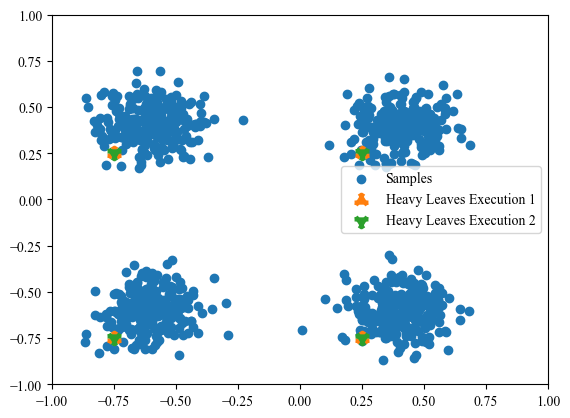

In [15]:
plt.scatter(truncnorm_data[:, 0], truncnorm_data[:, 1], label="Samples")
# plt.scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6], label="Mixture Centers")
plt.scatter(
    heavy_nodes1[:, 0],
    heavy_nodes1[:, 1],
    marker="1",
    linewidths=10,
    label="Heavy Leaves Execution 1",
)
plt.scatter(
    heavy_nodes1[:, 0],
    heavy_nodes1[:, 1],
    marker="2",
    linewidths=10,
    label="Heavy Leaves Execution 2",
)

ax = plt.gca()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.legend()
plt.show()

## Replicable Probability Mass Estimation

In [16]:
# eps should be a power of 10 e.g. 1e-3
def r_prob_mass(sampler, N: int, rho: float, eps: float, random_state: RandomState):
    assert 0 < rho < 1
    assert 0 < eps < 1

    alpha = 2 * eps / (rho / 3 + 1)
    eps_prime = eps * rho / 3 / (rho / 3 + 1)
    n = int(np.ceil((np.log(3 / rho) + N * np.log(2)) / (eps**2 * rho**2))) * 18
    decimals = int(np.log(1 / eps))
    print(alpha, eps_prime, n, decimals)

    samples = sampler(size=n)
    unique_samples, count = np.unique(samples, axis=0, return_counts=True)
    len(unique_samples) <= N
    count = count.astype(float) / n

    offset = random_state.uniform(low=0.0, high=alpha, size=len(unique_samples))
    rounded_count = np.around(count - offset, decimals=decimals) + offset

    # normalize estimates
    return unique_samples, rounded_count - (rounded_count.sum() - 1.0) / len(
        unique_samples
    )

In [17]:
samples1, mass1 = r_prob_mass(
    toy_sampler, N=3, rho=0.1, eps=0.1, random_state=RandomState(2)
)
samples2, mass2 = r_prob_mass(
    toy_sampler, N=3, rho=0.1, eps=0.1, random_state=RandomState(2)
)

assert np.isclose(mass1.sum(), 1.0)
assert np.isclose(mass2.sum(), 1.0)

print(samples1, mass1)
print(samples2, mass2)

0.1935483870967742 0.0032258064516129037 986526 2
0.1935483870967742 0.0032258064516129037 986526 2
[[0]
 [1]
 [2]] [0.30578932 0.29642119 0.39778949]
[[0]
 [1]
 [2]] [0.30578932 0.29642119 0.39778949]


## Replicable Coreset

In [18]:
def get_child_idx(node, point):
    if point[0] < node.point[0]:
        if point[1] < node.point[1]:
            return 0
        else:
            return 1
    else:
        if point[1] < node.point[1]:
            return 2
        else:
            return 3


def quad_tree_round(point, root: QuadTreeNode):
    output = np.array([0.0, 0.0])

    node = root
    while node is not None:
        child_idx = get_child_idx(node, point)

        if node.children[child_idx] is not None and node.children[child_idx].is_heavy:
            node = node.children[child_idx]
            output = node.point
            continue

        new_node = None
        for idx in range(len(QuadTreeNode.offsets)):
            if node.children[idx] is not None and node.children[idx].is_heavy:
                new_node = node.children[idx]
                output = new_node.point
                break

        node = new_node

    return output


def make_quad_tree_sampler(sampler, root: QuadTreeNode):
    def _quad_tree_sampler(size: int):
        samples = sampler(size)
        for i in range(len(samples)):
            samples[i] = quad_tree_round(samples[i], root)

        return samples

    return _quad_tree_sampler

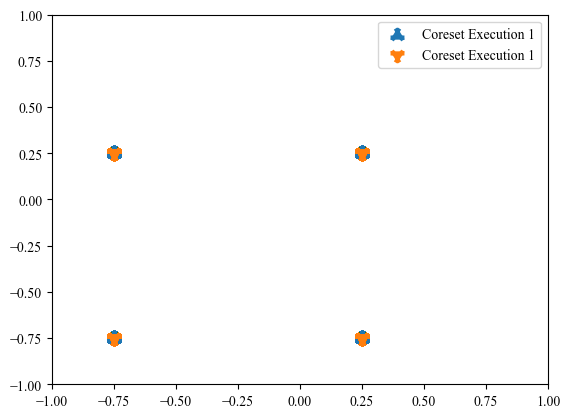

In [19]:
quad_tree_sampler1 = make_quad_tree_sampler(sample_mixture_truncnorm, root1)
quad_tree_sampler2 = make_quad_tree_sampler(sample_mixture_truncnorm, root2)

samples1 = quad_tree_sampler1(1000)
samples2 = quad_tree_sampler2(1000)

plt.scatter(
    samples1[:, 0],
    samples1[:, 1],
    marker="1",
    linewidths=10,
    label="Coreset Execution 1",
)
plt.scatter(
    samples2[:, 0],
    samples2[:, 1],
    marker="2",
    linewidths=10,
    label="Coreset Execution 1",
)

ax = plt.gca()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.legend()
plt.show()

In [20]:
def r_coreset(
    sampler,
    k: int,
    eps: float,
    rho: float,
    Gamma: float,
    beta: float,
    Delta: float = np.sqrt(2),
    skip_layers: int = 1,
    random_state: RandomState = None,
):
    assert 0 < eps < 1
    assert 0 < rho < 1

    if random_state is None:
        random_state = RandomState()

    root = r_quad_tree(
        sampler,
        k=k,
        eps=eps,
        rho=rho,
        Gamma=Gamma,
        beta=beta,
        Delta=Delta,
        skip_layers=skip_layers,
        random_state=random_state,
    )

    N = len(root.get_leaves())

    quad_tree_sampler = make_quad_tree_sampler(sampler, root)
    coreset, mass = r_prob_mass(
        quad_tree_sampler, N=N, rho=0.1, eps=0.1, random_state=random_state
    )

    return coreset, mass

## Replicable K-Means++

In [26]:
class MemorizedSampler:
    def __init__(self, sampler):
        self.sampler = sampler
        self.samples = []

    def __call__(self, size: int):
        samples = self.sampler(size)
        self.samples.append(samples.copy())
        return samples

    def get_samples(self):
        return np.concatenate(self.samples, axis=0)

In [27]:
memorized_truncnorm_sampler1 = MemorizedSampler(sample_mixture_truncnorm)
truncnorm_coreset1, truncnorm_mass1 = r_coreset(
    memorized_truncnorm_sampler1,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

memorized_truncnorm_sampler2 = MemorizedSampler(sample_mixture_truncnorm)
truncnorm_coreset2, truncnorm_mass2 = r_coreset(
    memorized_truncnorm_sampler2,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.17767355 0.03224091 0.03374132 0.00656869 0.17616133 0.03370587
 0.03331601 0.00604886 0.17793346 0.03402486 0.03343415 0.00587165
 0.17723643 0.03326875 0.03274892 0.00602524] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[0.00079618 0.01247346 0.01406582 0.1507431  0.00212314 0.01326964
 0.01433121 0.15525478 0.00079618 0.01194268 0.00981953 0.15233546
 0.00159236 0.0108811  0.01273885 0.15392781 0.2829087 ] 0.44242453191838704 3780
0.1935483870967742 0.0032258064516129037 1111284 2
3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.17698833 0.03315061 0.03394216 0.00635603 0.17851236 0.0343084
 0.03234724 0.00603705 0.17510987 0.03388309 0.03330419 0.00642692
 0.17689381 0.03300884 0.03361136 0.00611975] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[0.00159236 0.01326964 0.0108811  0.15100849 0.00079618 0.01353503
 0.01512739 0.14225053 0.00212314 0.01326964 0.01300425

used 1199765 samples
used 1199765 samples


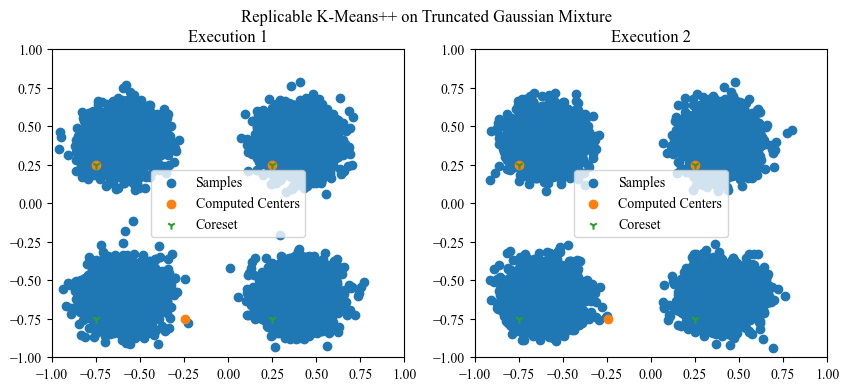

In [28]:
r_truncnorm_kmeans1 = KMeans(n_clusters=3).fit(
    truncnorm_coreset1, sample_weight=truncnorm_mass1
)
r_truncnorm_kmeans2 = KMeans(n_clusters=3).fit(
    truncnorm_coreset2, sample_weight=truncnorm_mass2
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

memorized_truncnorm_data1 = memorized_truncnorm_sampler1.get_samples()
print(f"used {len(memorized_truncnorm_data1)} samples")
memorized_truncnorm_data_indices1 = np.random.choice(
    memorized_truncnorm_data1.shape[0], 10000, replace=False
)

ax[0].scatter(
    memorized_truncnorm_data1[memorized_truncnorm_data_indices1, 0],
    memorized_truncnorm_data1[memorized_truncnorm_data_indices1, 1],
    label="Samples",
)
# ax[0].scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6])
ax[0].scatter(
    r_truncnorm_kmeans1.cluster_centers_[:, 0],
    r_truncnorm_kmeans1.cluster_centers_[:, 1],
    label="Computed Centers",
)

ax[0].scatter(
    truncnorm_coreset1[:, 0],
    truncnorm_coreset1[:, 1],
    marker="1",
    # linewidths=10,
    label="Coreset",
)

ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()
ax[0].set_title("Execution 1")

memorized_truncnorm_data2 = memorized_truncnorm_sampler2.get_samples()
print(f"used {len(memorized_truncnorm_data2)} samples")
memorized_truncnorm_data_indices2 = np.random.choice(
    memorized_truncnorm_data2.shape[0], 10000, replace=False
)

ax[1].scatter(
    memorized_truncnorm_data2[memorized_truncnorm_data_indices2, 0],
    memorized_truncnorm_data2[memorized_truncnorm_data_indices2, 1],
    label="Samples",
)
# ax[1].scatter([0.4, 0.4, -0.6, -0.6], [0.4, -0.6, 0.4, -0.6])
ax[1].scatter(
    r_truncnorm_kmeans2.cluster_centers_[:, 0],
    r_truncnorm_kmeans2.cluster_centers_[:, 1],
    label="Computed Centers",
)

plt.scatter(
    truncnorm_coreset2[:, 0],
    truncnorm_coreset2[:, 1],
    marker="1",
    # linewidths=10,
    label="Coreset",
)

ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].legend()
ax[1].set_title("Execution 2")

fig.suptitle("Replicable K-Means++ on Truncated Gaussian Mixture")

plt.savefig("r_truncnorm.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [29]:
memorized_moons_sampler1 = MemorizedSampler(sample_moons)
moons_coreset1, moons_mass1 = r_coreset(
    memorized_moons_sampler1,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

memorized_moons_sampler2 = MemorizedSampler(sample_moons)
moons_coreset2, moons_mass2 = r_coreset(
    memorized_moons_sampler2,
    k=3,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.03205189 0.01905628 0.0990974  0.09132366 0.0429682  0.04847361
 0.16689901 0.1665564  0.03204007 0.01918624 0.098932   0.09104012
 0.04368886 0.04868626] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[3.37048832e-02 4.90976645e-02 3.55626327e-02 4.80360934e-02
 2.65392781e-04 8.20063694e-02 2.65392781e-04 8.38641189e-02
 6.67197452e-01] 0.44242453191838704 3780
0.1935483870967742 0.0032258064516129037 1111284 2
3 2.040608101214162 0.02695274999999999
1
2
r_heavy_hitters...
57
84644
[0.03186286 0.01894996 0.09902651 0.09128822 0.04340532 0.04857993
 0.16668636 0.16683994 0.03213459 0.01896177 0.09919191 0.0916072
 0.04302727 0.04843816] 0.1548160463948315 84701
3
r_heavy_hitters...
12
3768
[3.55626327e-02 4.88322718e-02 3.15817410e-02 4.96284501e-02
 2.65392781e-04 8.43949045e-02 2.65392781e-04 8.22717622e-02
 6.67197452e-01] 0.44242453191838704 3780
0.1935483870967742 0.0032258064516129037 1111284 2


used 1199765 samples
used 1199765 samples


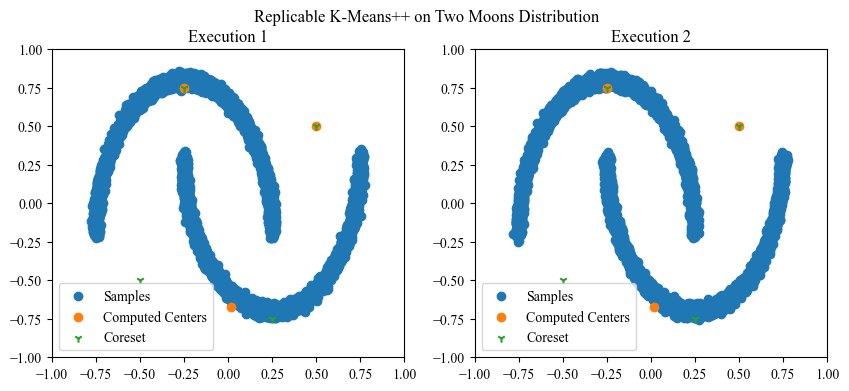

In [30]:
r_moons_kmeans1 = KMeans(n_clusters=3).fit(moons_coreset1, sample_weight=moons_mass1)
r_moons_kmeans2 = KMeans(n_clusters=3).fit(moons_coreset2, sample_weight=moons_mass2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

memorized_moons_data1 = memorized_moons_sampler1.get_samples()
print(f"used {len(memorized_moons_data1)} samples")
memorized_moons_data_indices1 = np.random.choice(
    memorized_moons_data1.shape[0], 10000, replace=False
)

ax[0].scatter(
    memorized_moons_data1[memorized_moons_data_indices1, 0],
    memorized_moons_data1[memorized_moons_data_indices1, 1],
    label="Samples",
)
ax[0].scatter(
    r_moons_kmeans1.cluster_centers_[:, 0],
    r_moons_kmeans1.cluster_centers_[:, 1],
    label="Computed Centers",
)

ax[0].scatter(
    moons_coreset1[:, 0],
    moons_coreset1[:, 1],
    marker="1",
    # linewidths=10,
    label="Coreset",
)

ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()
ax[0].set_title("Execution 1")

memorized_moons_data2 = memorized_moons_sampler2.get_samples()
print(f"used {len(memorized_moons_data2)} samples")
memorized_moons_data_indices2 = np.random.choice(
    memorized_moons_data2.shape[0], 10000, replace=False
)

ax[1].scatter(
    memorized_moons_data2[memorized_moons_data_indices2, 0],
    memorized_moons_data2[memorized_moons_data_indices2, 1],
    label="Samples",
)
ax[1].scatter(
    r_moons_kmeans2.cluster_centers_[:, 0],
    r_moons_kmeans2.cluster_centers_[:, 1],
    label="Computed Centers",
)

plt.scatter(
    moons_coreset2[:, 0],
    moons_coreset2[:, 1],
    marker="1",
    # linewidths=10,
    label="Coreset",
)

ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].legend()
ax[1].set_title("Execution 2")

fig.suptitle("Replicable K-Means++ on Two Moons Distribution")

plt.savefig("r_moons.pdf", format="pdf", bbox_inches="tight")

plt.show()